In [1]:
size =   15#@param {type:"integer"}
dimension = "High" #@param ["High", "Low"]
epochs =  20 #@param {type:"integer"}
A_plus = 0.01 #@param {type:"number"}
A_minus = -0.0011 #@param {type: "number"}
lateralDelay = 5 #@param {type: "number"}

In [2]:
#@title Parameters
from ipywidgets import FloatText, Checkbox, VBox, Dropdown
import ipywidgets as widgets

currentAmp = FloatText(description='Amplitude:', value=0.1)
sets = FloatText(description='sets:', value=15)
noiseSD = FloatText(description='noiseSD:', value=0.01)

vb = VBox(children = [currentAmp, sets])
with_noise = Checkbox(description='Add noise')

def add_noise(button):
    if button['new']:
        vb.children = [currentAmp, sets, noiseSD]
    else:
        vb.children = [currentAmp, sets]

with_noise.observe(add_noise, names='value')
display(with_noise)
display(vb)

Checkbox(value=False, description='Add noise')

In [3]:
#@title Distribution
from ipywidgets import FloatText, Checkbox, VBox, Dropdown
import ipywidgets as widgets

distribution = Dropdown(description='distribution:', options=["uniform", "normal", "poisson"], value="uniform")
low = FloatText(description='low:', value=1)
high = FloatText(description='high:', value=1.5)
leng = FloatText(description='size:', value=sets.value)
mean = FloatText(description='mean:', value=1)
sd = FloatText(description='SD:', value=0.5)
lam = FloatText(description='lam', value=3)

vb2 = VBox(children = [low, high, leng])

def change_widgets(button):
    if button['new'] == "uniform":
        vb2.children = [low, high, leng]
    elif button['new'] == "normal":
        vb2.children = [mean, sd, leng]
    elif button['new'] == "poisson":
        vb2.children = [lam, sets]

distribution.observe(change_widgets, names='value')
display(distribution)
display(vb2)

Dropdown(description='distribution:', options=('uniform', 'normal', 'poisson'), value='uniform')

### Install Neuron

In [4]:
pip install pandas neuron

     |████████████████████████████████| 15.0 MB 15.5 MB/s 


In [5]:
# %load_ext google.colab.data_table
# import pandas
# data = {'Time taken': ['5 sets (with learning)', '5 sets (without learning)', '30 sets (with learning)', '30 sets (without)'], 'Time (s)': [64.94386959075928, 64.94386959075928-47.318169593811035, 163.1467843055725, 163.1467843055725-123.22148942947388]}  
# pandas.DataFrame(data)

### Import prerequisites

In [6]:
import time
totalstart = time.time()
import os
if os.getcwd() != "/content":
    # we are not in google colab, assume hebbian library is in current dir
    from hebb import ORN, MCELL, GCELL
else:
    # download from git
    import shutil, requests
    url = 'https://cloud.operationtulip.com/s/t8nbn8Y582w94P3/download/git.zip'
    response = requests.get(url, stream=True)
    with open('git.zip', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    import zipfile
    with zipfile.ZipFile('git.zip', 'r') as zip_ref:
        zip_ref.extractall('')


In [7]:
!nrnivmodl &>/dev/null

In [8]:
from neuron import h #.h is a HOC object instance & gui from neuron can also be imported 
from math import pi                  
from neuron.units import ms,mV
from hebb_test import ORN, MCELL, GCELL
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation
pc = h.ParallelContext()
import random  
import matplotlib.pyplot as plt1

from bokeh.io import output_notebook
import bokeh.plotting as plt2
output_notebook()

import seaborn as sns

## Helper Functions

In [9]:
def stairstep(lo: float, hi: float, duration: int, max_duration: int = 200, noise: list = []) -> list:
    # duration and max_duration are in ms
    ans = [lo if i < duration else hi for i in range(0,max_duration)]
    if len(noise) == 0:
        return ans
    else:
        assert len(ans) == len(noise)
        return [ans[i]+noise[i] for i in range(len(ans))]
    # return [0+0.8*(i/duration) if i < duration else 0 for i in range(0,max_duration)]
    # visualize input 

In [10]:
def netConMaker(source, dest, weights, delay, threshold, place='axon', type='exc'):
    # print(source, dest)
    if place == 'axon':
        if type == 'exc':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendexcisyn, sec=source.axon)
        elif type == 'inh':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendinhisyn, sec=source.axon)
    elif place == 'soma':
        if type == 'exc':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendexcisyn, sec=source.soma)
        elif type == 'inh':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendinhisyn, sec=source.soma)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [11]:
def latConMaker(source, dest, weights, delay, threshold, type='exc'):
    if type == 'exc':
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendexcisyn, sec=source.dend)
    else:
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendinhisyn, sec=source.dend)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [12]:
%matplotlib inline
def plotCell(source, name, addendum=''):
    recording_cell = source
    cell_axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
    cell_dend = h.Vector().record(recording_cell.dend(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    h.finitialize(-70 * mV)
    h.continuerun(300 * ms)

    f = plt1.figure(figsize=(16,9))
    ax = f.add_subplot(1,1,1)
    ax.plot(t, list(cell_axon), label=name+' axon '+addendum)
    ax.plot(t, list(cell_dend), label=name+' dendrite '+addendum)
    ax.legend(loc="upper right")
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('v (mV)')
    plt1.show()

In [13]:
import math
def generate_L_weight_delta(first, second):
    A_plus = 0.01
    A_minus = -0.011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

In [14]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

## Network Definitions

In [15]:
class AON:
    def __init__(self,M,weights,delay1=1,delay2=2,delay3=3,delay4=4):
        wMM=weights[0]
        wMG=weights[1]
        wGM=weights[2]
        wGG=weights[3]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 5

        self.M1=MCELL(1,self.M)
        self.M2=MCELL(2,self.M)
        self.G1=GCELL(3,self.M)
        self.G2=GCELL(4,self.M)
        self.cells = [self.M1, self.M2, self.G1, self.G2]
        
        self.nc0 = netConMaker(self.M1, self.M2, wMM, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to E2
        self.nc1 = netConMaker(self.M2, self.M1, wMM, delay2+self.maindelay, self.th, 'soma') #Connecting E2 to E1
        self.nc2 = netConMaker(self.M2, self.G1, wMG, delay2+self.maindelay, self.th, 'soma') #Connecting E2 to I1
        self.nc3 = netConMaker(self.G1, self.M2, wGM, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to E2
        self.nc4 = netConMaker(self.G1, self.G2, wGG, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to I2
        self.nc5 = netConMaker(self.G2, self.G1, wGG, delay4+self.maindelay, self.th, 'soma', type='inh') #Connecting I2 to I1
        self.nc6 = netConMaker(self.G2, self.M1, wGM, delay4+self.maindelay, self.th, 'soma', type='inh') #Connecting I2 to E1
        self.nc7 = netConMaker(self.M1, self.G2, wMG, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to I2
        self.nc8 = netConMaker(self.M1, self.G1, wMG, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to I1
        self.nc9 = netConMaker(self.G1, self.M1, wGM, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to E1

In [16]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:

    def __init__(self,M,weights,delay1=0,delay2=2,delay3=4,delay4=6):
        wMM=weights[0]
        wMG=weights[1]
        wGM=weights[2]
        wGG=weights[3]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 5
        
        #Making 2 neurons
        self.orn = ORN(1,self.M)
        self.P1=MCELL(2,self.M)
        self.P2=MCELL(3,self.M)
        self.cells = [self.orn, self.P1, self.P2]
        
        #Giving current pulse
        self.stim = h.IClamp(self.orn.dend(0.5))  #P1.soma to P1.dend
        # self.stimArr = [h.IClamp(self.orn.ciliumArr[i](0.5)) for i in range(len(self.orn.ciliumArr))]
        if with_noise.value == True:
            self.noise = np.random.normal(0, noiseSD.value, 100)
            self.input = h.Vector(stairstep(0,currentAmp.value,10,100,self.noise))
            self.tv = h.Vector([i for i in range(100)])
            self.stim.delay = 10
            self.stim.dur = 100
            self.stim.amp = 0
            self.input.play(self.stim._ref_amp, self.tv, True) 
        else:
            self.stim.delay = 10
            self.stim.dur = 100
            self.stim.amp = currentAmp.value
        
        self.nc0 = netConMaker(self.orn, self.P1, wMM, self.maindelay+delay2, self.th, 'soma') #Connecting ORN to P1
        self.nc1 = netConMaker(self.P1, self.P2, wMM, self.maindelay+delay3, self.th, 'soma') #Connecting P1 to P2
        self.nc2 = netConMaker(self.P2, self.P1, wMM, self.maindelay+delay3, self.th, 'soma') #Connecting P2 to P1
    
        # 4-coupled

        self.M1=MCELL(1,self.M)
        self.M2=MCELL(2,self.M)
        self.G1=GCELL(3,self.M)
        self.G2=GCELL(4,self.M)
        self.cells.extend([self.M1, self.M2, self.G1, self.G2])

        self.nc14 = netConMaker(self.orn, self.M1, wMM, delay1+self.maindelay, self.th, 'soma')
        self.nc3 = netConMaker(self.P1, self.M1, wMM, delay1+self.maindelay, self.th, 'soma')
        self.nc4 = netConMaker(self.M1, self.M2, wMM, delay2+self.maindelay, self.th, 'soma') #Connecting M1 to M2
        self.nc5 = netConMaker(self.M2, self.M1, wMM, delay2+self.maindelay, self.th, 'soma') #Connecting M2 to M1
        self.nc6 = netConMaker(self.M2, self.G1, wMG, delay2+self.maindelay, self.th, 'soma') #Connecting M2 to G1
        self.nc7 = netConMaker(self.G1, self.M2, wGM, delay2+self.maindelay, self.th, 'soma', type='inh') #Connecting G1 to M2
        self.nc8 = netConMaker(self.G1, self.G2, wGG, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting G1 to G2
        self.nc9 = netConMaker(self.G2, self.G1, wGG, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting G2 to G1
        self.nc10 = netConMaker(self.G2, self.M1, wGM, delay4+self.maindelay, self.th, 'soma', type='inh') #Connecting G2 to M1
        self.nc11 = netConMaker(self.M1, self.G2, wMG, delay4+self.maindelay, self.th, 'soma') #Connecting M1 to G2
        self.nc12 = netConMaker(self.M1, self.G1, wMG, delay1+self.maindelay, self.th, 'soma') #Connecting M1 to G1
        self.nc13 = netConMaker(self.G1, self.M1, wGM, delay1+self.maindelay, self.th, 'soma', type='inh') #Connecting G1 to M1

In [17]:

class LATERAL:
    """Laterally coupling N-2 coupled neurons
    """
    def __init__(self,N,weights,delay1=0,delay2=2,delay3=4,delay4=6):
        wMML=weights[1]
        wGGL=weights[5]
        
        self.N = N
        self.th = -70
        self.maindelay = lateralDelay
        self.sets = [CONNECTING(i, weights) for i in range(N)]
            
        self.twoCupArr = []
        for r in range(0,N-1):
          #Connecting P1[0] to P1[1]
          # make a list for easier access
          netConList = []
          netConList.append(latConMaker(self.sets[r].P1, self.sets[r+1].P1,wMML,self.maindelay+delay2,self.th)) #P1[0] to P1[1]
          netConList.append(latConMaker(self.sets[r+1].P1, self.sets[r].P1, wMML, self.maindelay+delay2,self.th))

          self.twoCupArr.append(netConList)
        self.fourCupArr = []
        for r in range(1,N-1):
            for j in range(N-r):
                netConList = []
                netConList.append(latConMaker(self.sets[j].M1, self.sets[j+r].M1, wMML, self.maindelay+delay3, self.th)) #Connect M1[0] to M1[1]
                netConList.append(latConMaker(self.sets[j+r].M1, self.sets[j].M1, wMML, self.maindelay+delay3, self.th)) #Connect M1[1] to M1[0]
                netConList.append(latConMaker(self.sets[j].G1, self.sets[j+r].G1, wGGL, self.maindelay+delay2, self.th, 'inh')) #Connecting G1[0] to G1[1]
                netConList.append(latConMaker(self.sets[j+r].G1, self.sets[j].G1, wGGL, self.maindelay+delay2, self.th, 'inh')) #Connecting G1[1] to G1[0]
                self.fourCupArr.append(netConList)

        # add AON and PC
        self.AON = AON(5,weights)
        self.PC = AON(6,weights)
        self.DPC = GCELL(7,self.N)
        # add noise to AON's M1
        self.stim = h.IClamp(self.AON.M1.dend(0.5))  #P1.soma to P1.dend
        self.noise = np.random.normal(0, 0.1, 100)
        self.input = h.Vector(self.noise)
        self.tv = h.Vector([i for i in range(100)])
        self.input.play(self.stim._ref_amp, self.tv, True)
        self.otherNetCons = []
        self.otherNetCons.append(netConMaker(self.sets[0].M1, self.AON.M1, wMML, self.maindelay+delay2, self.th, 'soma')) # 4-coupled M1 -> AON's E1
        for i in self.sets:
            for j in self.sets:
                if i != j:
                    self.otherNetCons.append(netConMaker(i.P1, j.P1, wMML, self.maindelay+delay2, self.th, 'soma')) # all-to-all in P1
                    self.otherNetCons.append(netConMaker(i.M1, j.M1, wMML, self.maindelay+delay3, self.th, 'soma')) # all-to-all in M1
                    self.otherNetCons.append(netConMaker(i.G1, j.G1, wGGL, self.maindelay+delay2, self.th, 'soma')) # all-to-all in M1

        for i in self.sets:
            self.otherNetCons.append(netConMaker(self.AON.M1, i.P2, wMML, self.maindelay+delay2, self.th, 'soma')) # AON E1 -> 2-coupled P2
        if dimension == "High":
            self.otherNetCons.append(netConMaker(self.PC.M1, self.AON.G1, wMML, self.maindelay+delay3+10, self.th, 'soma')) # PC's A1 to AON's I1
        self.otherNetCons.append(netConMaker(self.sets[0].M1, self.PC.M1, wMML, self.maindelay+delay2, self.th, 'soma')) # M1 to A1
        for i in self.sets:
            self.otherNetCons.append(netConMaker(self.AON.M1, i.G1, wMML, self.maindelay+delay2, self.th, 'soma')) # AON's E1 -> 4-coupled G1
        
        self.otherNetCons.append(netConMaker(self.PC.G1, self.DPC, wMML/100000, self.maindelay+delay3, self.th, 'soma', 'inh')) # PC's B1 -> DPC
        self.otherNetCons.append(netConMaker(self.DPC, self.PC.G1, wMML/100000, self.maindelay+delay3, self.th, 'soma')) # DPC -> PC's B1
        if dimension == "High":
            for i in self.sets:
                self.otherNetCons.append(netConMaker(self.DPC, i.G1, wMML/100000, self.maindelay+delay3+10, self.th))# DPC to G1 
        self.otherNetCons.append(netConMaker(self.sets[-1].G1, self.DPC, wMML, self.maindelay+4, self.th, 'soma'))
        


In [18]:
import numpy as np
if distribution.value == "uniform":
    weights = np.random.uniform(low.value, high.value, 2*int(leng.value)-1)
elif distribution.value == "normal":
    weights = np.random.normal(mean.value, sd.value, 2*int(leng.value)-1)
elif distribution.value == "poisson":
    weights = np.random.poisson(lam.value, 2*int(leng.value)-1)

In [19]:
#Give N value to get N no. of 2 coupled neurons laterally connected
#given_input_from_user = int(input('Enter the number of 2 coupled sets required: '))
import numpy as np
# size = 5
low, high = 1, 5
# all_weights = np.random.uniform(low, high,2*given_input_from_user-1)
# all_weights = [4.65058555, 2.92840154, 3.68134116, 1.30487304, 1.07771946, 3.15136447, 1.04247865, 2.29878494, 2.01195344]
# all_weights = [0.95336892, 0.87793015, 0.71060386, 0.88298338, 0.84561174, 0.5006465, 0.60983793, 0.88890724, 0.85189888]
L1=LATERAL(size,weights)

# Show Topology

In [20]:
h.topology()


|-|       Set [1]_ORNcell [1].soma(0-1)
   `|       Set [1]_ORNcell [1].dend(0-1)
   `|       Set [1]_ORNcell [1].dendriticknob(1-0)
   `-|       Set [1]_ORNcell [1].cilium0(0-1)
   `-|       Set [1]_ORNcell [1].cilium1(0-1)
   `-|       Set [1]_ORNcell [1].cilium2(0-1)
   `-|       Set [1]_ORNcell [1].cilium3(0-1)
 `|       Set [1]_ORNcell [1].axon(0-1)
|-|       Set [1]_Mcell [2].soma(0-1)
   `|       Set [1]_Mcell [2].dend(0-1)
 `|       Set [1]_Mcell [2].axon(0-1)
|-|       Set [1]_Mcell [3].soma(0-1)
   `|       Set [1]_Mcell [3].dend(0-1)
 `|       Set [1]_Mcell [3].axon(0-1)
|-|       Set [1]_Mcell [1].soma(0-1)
   `|       Set [1]_Mcell [1].dend(0-1)
 `|       Set [1]_Mcell [1].axon(0-1)
|-|       Set [1]_Mcell [2].soma(0-1)
   `|       Set [1]_Mcell [2].dend(0-1)
 `|       Set [1]_Mcell [2].axon(0-1)
|--|       Set [1]_Gcell [3].soma(0-1)
    `-|       Set [1]_Gcell [3].dend(0-1)
 `-|       Set [1]_Gcell [3].axon(0-1)
|--|       Set [1]_Gcell [4].soma(0-1)
    `-|       Set [

1.0

In [21]:
# # from neuron import h, gui
# from matplotlib import pyplot as plt
# import numpy
# for sec in h.allsec():
#     sec.nseg = 1
#     for seg in sec:
#         seg.diam = numpy.interp(seg.x, [0, 1], [10, 40])

# s = h.Shape()
# s.show(1)
# # s.color(2, sec=a) # color section "a" red
# # h.topology()
# h.finitialize(-65)
        
# fig = plt.figure()
# fig.set_figwidth(16)
# fig.set_figheight(9)
# ax = fig.add_subplot(projection='3d')

# MCell=[]
# GCell=[]
# ORNCell=[]
# ORNCellPlot=[[],[],[]]
# MCellPlot=[[],[],[]]
# GCellPlot=[[],[],[]]
# h.finitialize()
# for sec in h.allsec():
#     if 'ORNcell' in repr(sec):
#         ORNCell.append(sec)
#     elif 'Mcell' in repr(sec):
#         MCell.append(sec)
#     elif 'Gcell' in repr(sec):
#         GCell.append(sec)

# for sec in ORNCell:
#     for i in range(sec.n3d()):
#         ORNCellPlot[0].append(sec.x3d(i))
#         ORNCellPlot[1].append(sec.y3d(i))
#         ORNCellPlot[2].append(sec.z3d(i))
# for sec in MCell:
#     for i in range(sec.n3d()):
#         MCellPlot[0].append(sec.x3d(i))
#         MCellPlot[1].append(sec.y3d(i))
#         MCellPlot[2].append(sec.z3d(i))
# for sec in GCell:
#     for i in range(sec.n3d()):
#         GCellPlot[0].append(sec.x3d(i))
#         GCellPlot[1].append(sec.y3d(i))
#         GCellPlot[2].append(sec.z3d(i))
# #         print(sec.x3d(i), sec.y3d(i), sec.z3d(i))
# # print(ORNCellPlot, MCellPlot,GCellPlot)
# ax.scatter(ORNCellPlot[0], ORNCellPlot[1], ORNCellPlot[2], label='ORN')
# ax.scatter(MCellPlot[0], MCellPlot[1], MCellPlot[2], label='MCell')
# ax.scatter(GCellPlot[0], GCellPlot[1], GCellPlot[2], label='GCell')

# ax.set_xlabel('X coord')
# ax.set_ylabel('Y coord')
# ax.set_zlabel('Z coord')
# ax.legend()

# plt.show()

In [22]:
# from neuron import h, gui2
# gui2.set_backend('jupyter')
# ps = gui2.PlotShape()
# ps.variable('v')
# ps.show(0)

In [23]:
import math
def drawline(pre, post, ax):
#     ps.beginline()
#     print("Pre:", pre.axon.x3d(1), pre.axon.y3d(1), pre.axon.z3d(1))
#     print("Post:", post.axon.x3d(1), post.axon.y3d(1), post.axon.z3d(1))

    pre_x, pre_y, pre_z = pre.axon.x3d(0), pre.axon.y3d(0), pre.axon.z3d(0)
    post_x, post_y, post_z = post.axon.x3d(1), post.axon.y3d(1), post.axon.z3d(1)
#     print("pre_x", pre_x, post_x,"pre_y", pre_y, post_y,"pre_z", pre_z, post_z)
    ax.plot([pre_x, post_x], [pre_y, post_y], [pre_z, post_z])

In [24]:
%matplotlib notebook
from neuron import h
from matplotlib import pyplot
ps = h.PlotShape(False)  # False tells h.PlotShape not to use NEURON's gui
ps.plot(pyplot)
fig = pyplot.figure(1)
ax = fig.axes[0]
print("Two-coupled")
for i in L1.twoCupArr:
    # get into netconList
    for j in i:
        # get P1 and P2
        drawline(j.precell(), j.postcell(), ax)
print('Four-coupled:')
for i in L1.fourCupArr:
    # get into netConList
    for j in i:
        drawline(j.precell(), j.postcell(),ax)


pyplot.show()
# ps.show()

<IPython.core.display.Javascript object>

Two-coupled
Four-coupled:


# Voltages before Learning

In [25]:
%matplotlib inline

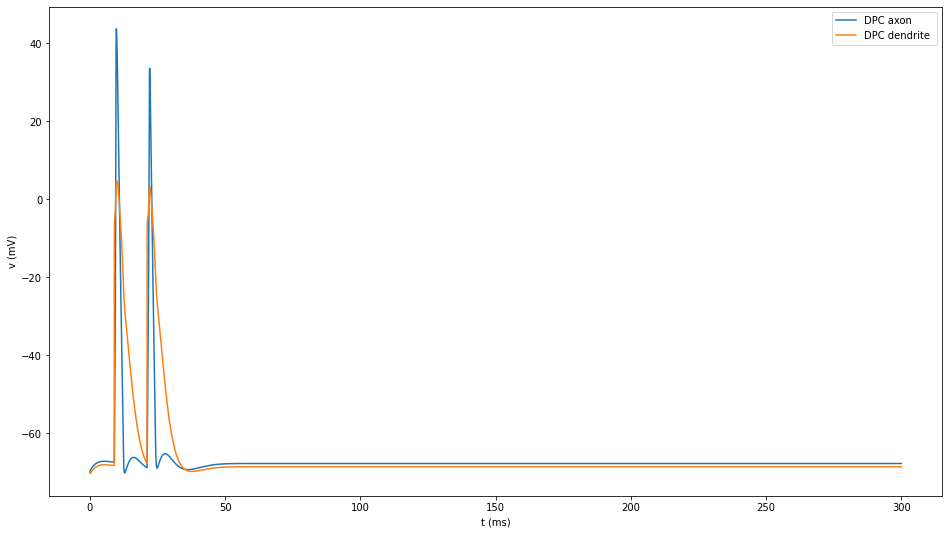

In [26]:
plotCell(L1.DPC, 'DPC')

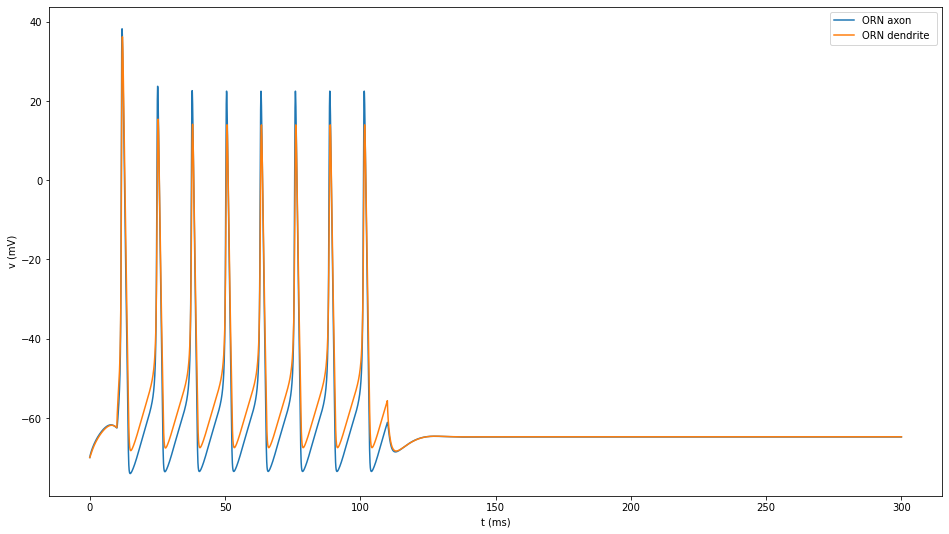

In [27]:
plotCell(L1.sets[0].orn, 'ORN')

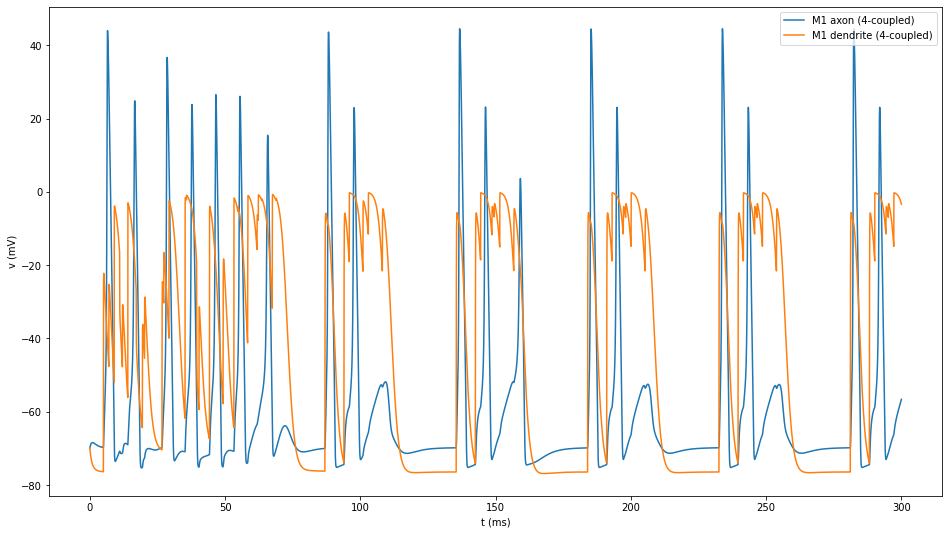

In [28]:
plotCell(L1.sets[0].M1, 'M1', '(4-coupled)')

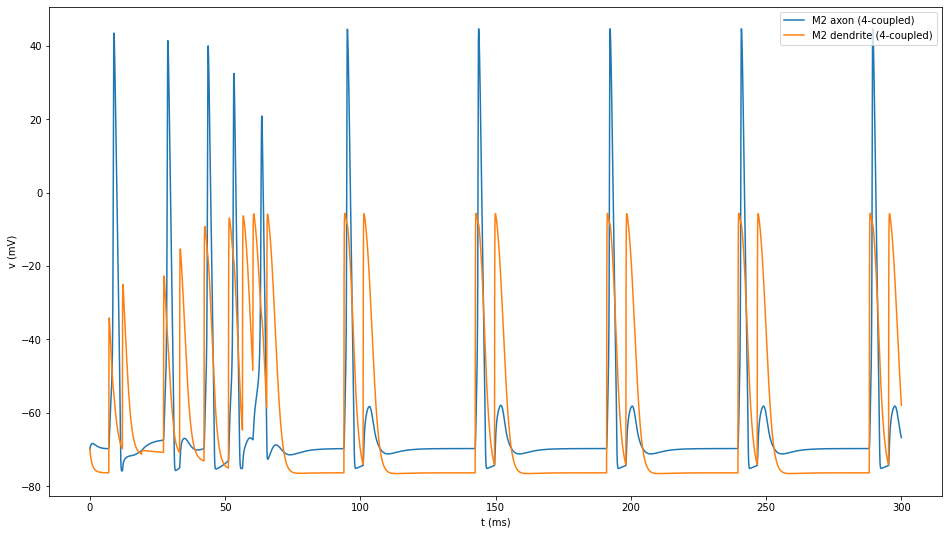

In [29]:
plotCell(L1.sets[0].M2, 'M2', '(4-coupled)')

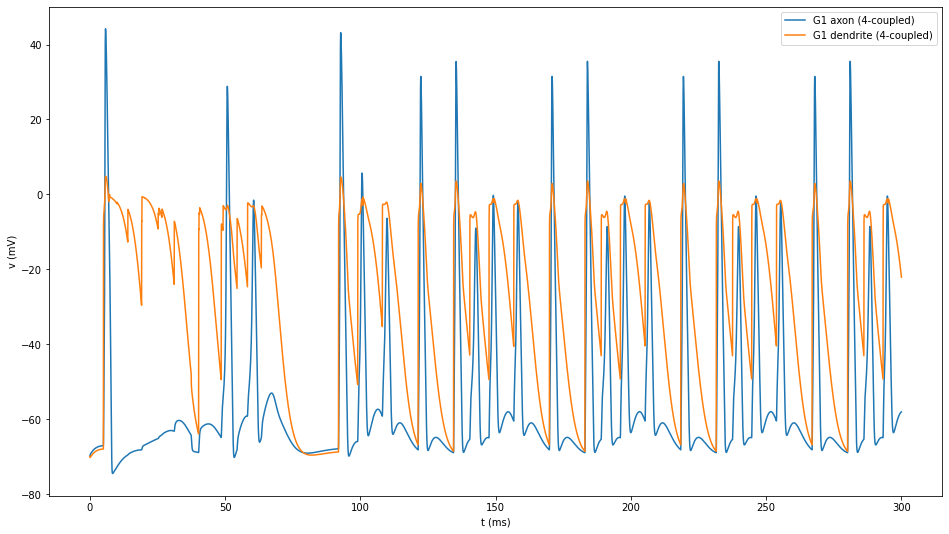

In [30]:
plotCell(L1.sets[0].G1, 'G1', '(4-coupled)')

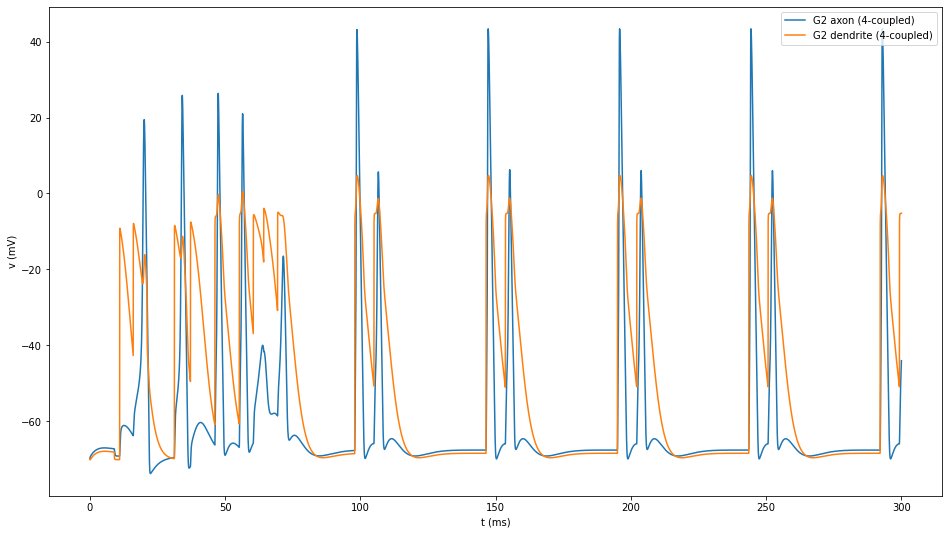

In [31]:
plotCell(L1.sets[0].G2, 'G2', '(4-coupled)')

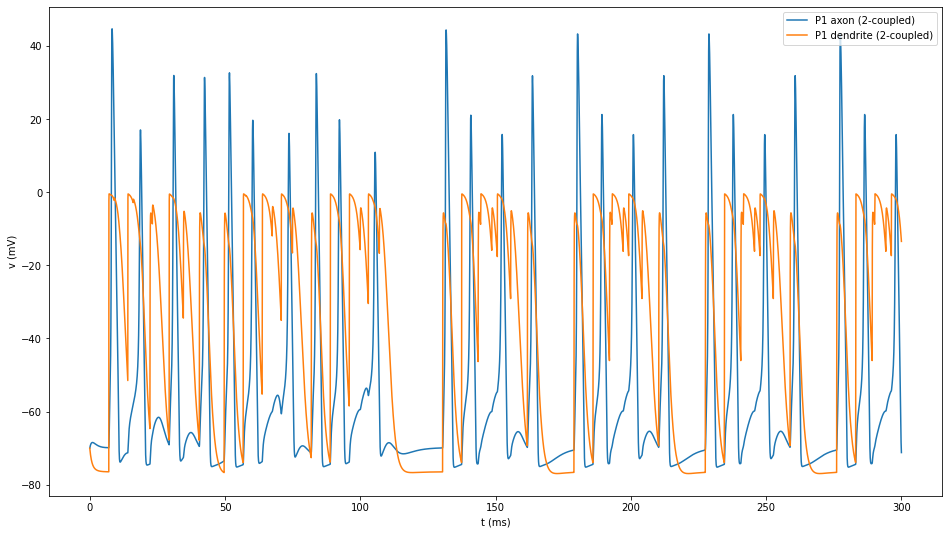

In [32]:
plotCell(L1.sets[0].P1, 'P1', '(2-coupled)')

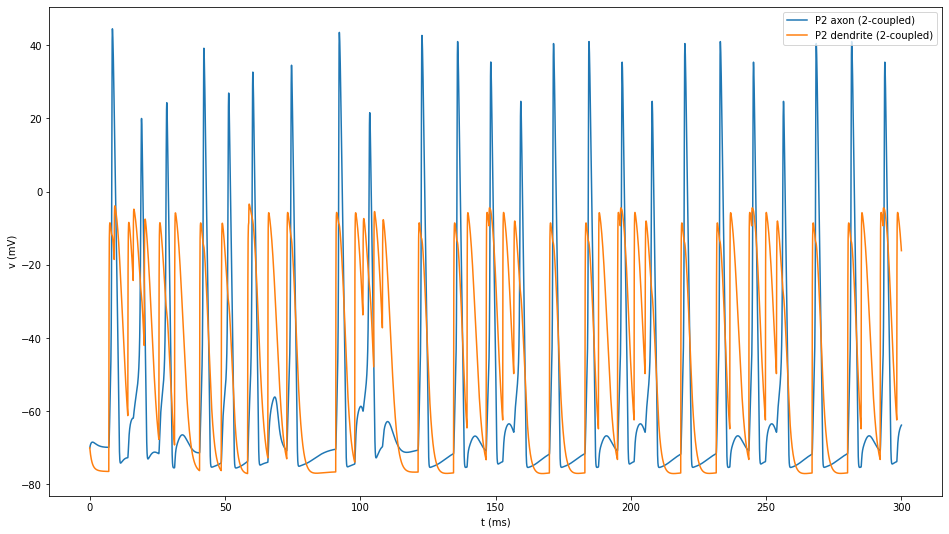

In [33]:
plotCell(L1.sets[0].P2, 'P2', '(2-coupled)')

# Voltage vs Voltage analysis

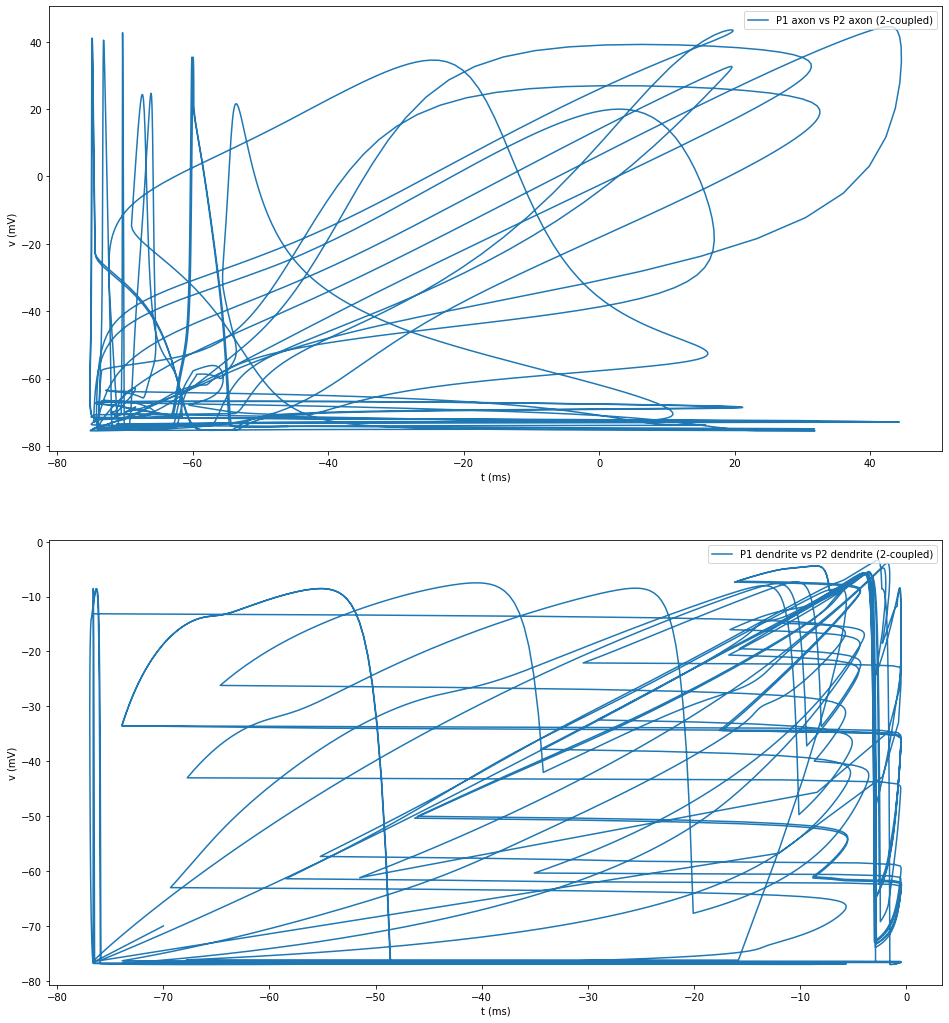

In [34]:
%matplotlib inline
recording_cell = L1.sets[0].P1
recording_cell_2 = L1.sets[0].P2
axon_m1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
dend_m1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
axon_m2 = h.Vector().record(recording_cell_2.axon(0.5)._ref_v)
dend_m2 = h.Vector().record(recording_cell_2.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)

# f = plt2.figure(x_axis_label='v (mV)', y_axis_label='v (mV)')
# f.line(list(axon_m1), list(axon_m2), line_width=1,legend_label='P1 axon vs P2 axon (2-coupled)',line_color='black')
# f2 = plt2.figure(x_axis_label='v (mV)', y_axis_label='v (mV)')
# f2.line(list(dend_m1), list(dend_m2), line_width=2,legend_label='P1 dendrite vs P2 dendrite (2-coupled)',line_color='black')
# plt2.show(f)
# plt2.show(f2)

fig, axs = plt1.subplots(2, figsize=(16,18))
axs[0].plot(list(axon_m1), list(axon_m2), label='P1 axon vs P2 axon (2-coupled)')
axs[0].legend(loc="upper right")
axs[0].set_xlabel('t (ms)')
axs[0].set_ylabel('v (mV)')
axs[1].plot(list(dend_m1),list(dend_m2), label='P1 dendrite vs P2 dendrite (2-coupled)')
axs[1].legend(loc="upper right")
axs[1].set_xlabel('t (ms)')
axs[1].set_ylabel('v (mV)')
plt1.show()

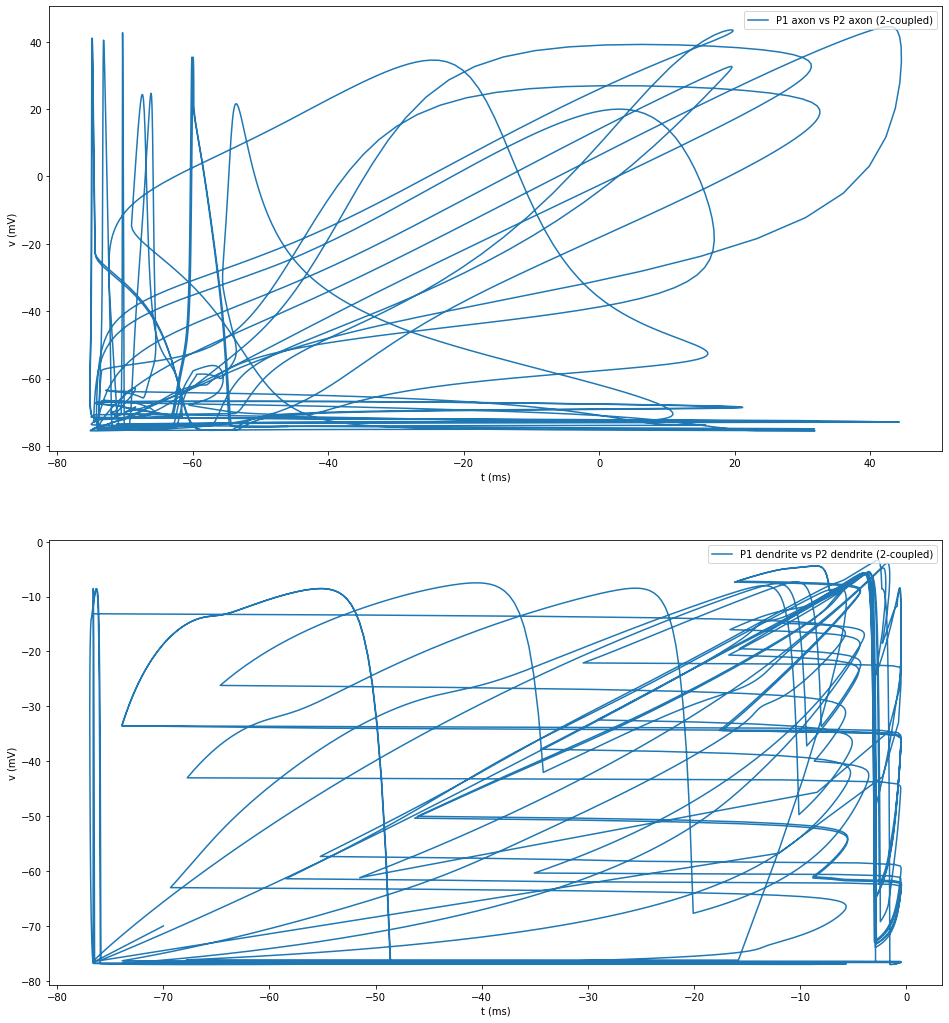

In [35]:
recording_cell = L1.sets[0].P1
recording_cell_2 = L1.sets[0].P2
axon_m1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
dend_m1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
axon_m2 = h.Vector().record(recording_cell_2.axon(0.5)._ref_v)
dend_m2 = h.Vector().record(recording_cell_2.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)

fig, axs = plt1.subplots(2, figsize=(16,18))
axs[0].plot(list(axon_m1), list(axon_m2), label='P1 axon vs P2 axon (2-coupled)')
axs[0].legend(loc="upper right")
axs[0].set_xlabel('t (ms)')
axs[0].set_ylabel('v (mV)')
axs[1].plot(list(dend_m1),list(dend_m2), label='P1 dendrite vs P2 dendrite (2-coupled)')
axs[1].legend(loc="upper right")
axs[1].set_xlabel('t (ms)')
axs[1].set_ylabel('v (mV)')
plt1.show()

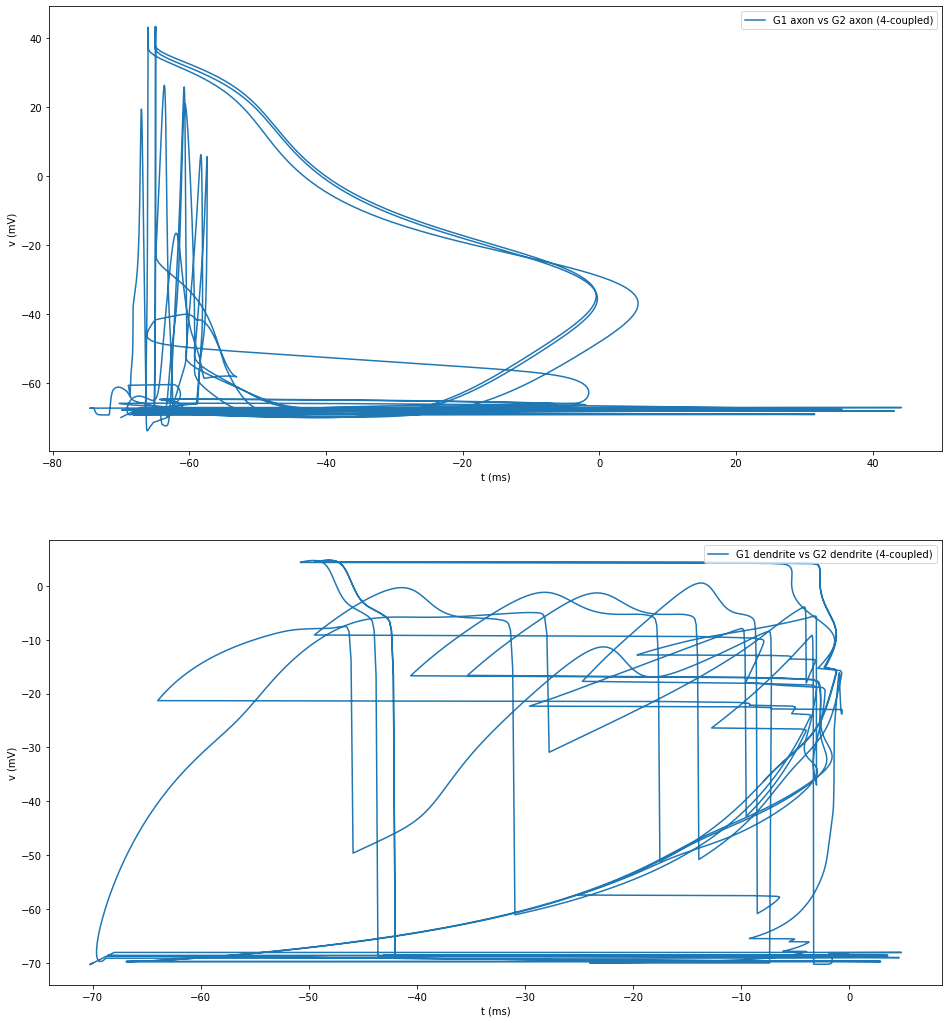

In [36]:
recording_cell = L1.sets[0].G1
recording_cell_2 = L1.sets[0].G2
axon_m1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
dend_m1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
axon_m2 = h.Vector().record(recording_cell_2.axon(0.5)._ref_v)
dend_m2 = h.Vector().record(recording_cell_2.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)
fig, axs = plt1.subplots(2, figsize=(16,18))
axs[0].plot(list(axon_m1), list(axon_m2), label='G1 axon vs G2 axon (4-coupled)')
axs[0].legend(loc="upper right")
axs[0].set_xlabel('t (ms)')
axs[0].set_ylabel('v (mV)')
axs[1].plot(list(dend_m1),list(dend_m2), label='G1 dendrite vs G2 dendrite (4-coupled)')
axs[1].legend(loc="upper right")
axs[1].set_xlabel('t (ms)')
axs[1].set_ylabel('v (mV)')
plt1.show()

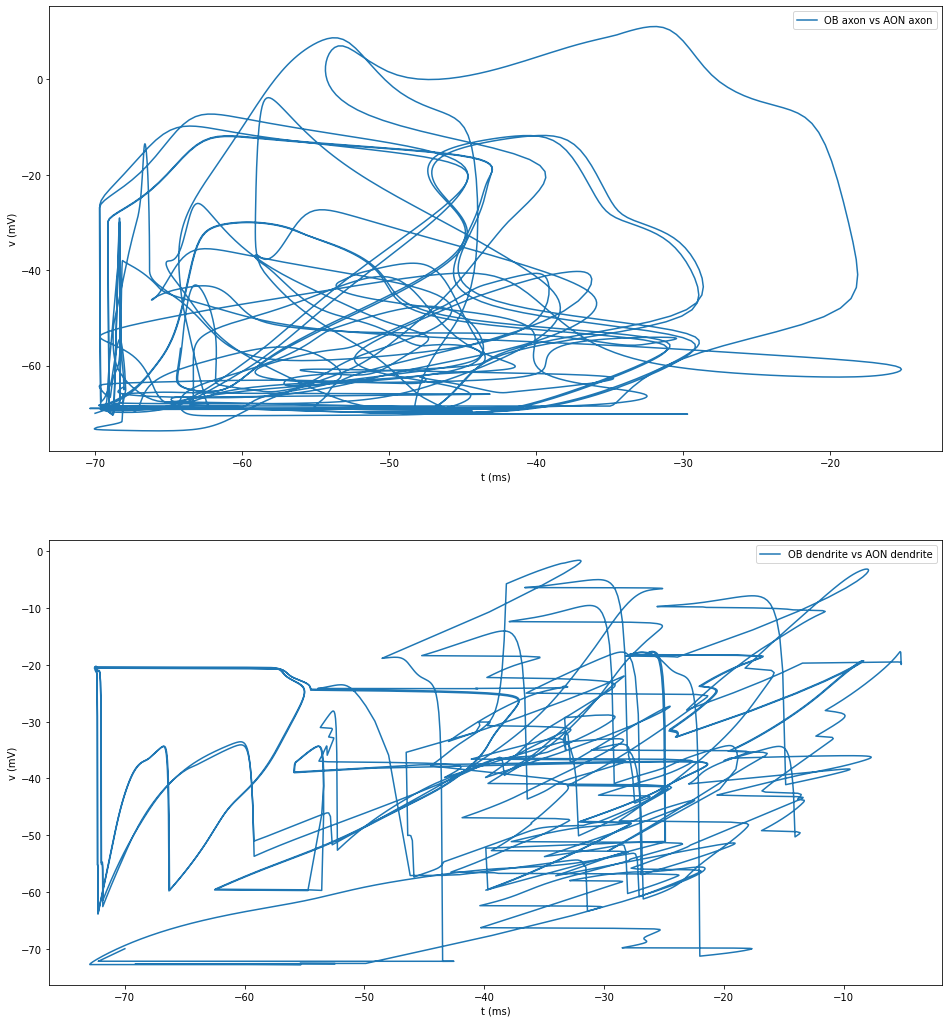

In [37]:
import numpy

OB_axon = []
OB_dend = []
AON_axon = []
AON_dend = []
for i in L1.sets:
    for j in enumerate(i.cells):
        if j[0] > 2:
            OB_axon.append(h.Vector().record(j[1].axon(0.5)._ref_v))
            OB_dend.append(h.Vector().record(j[1].dend(0.5)._ref_v))

for i in L1.AON.cells:
    AON_axon.append(h.Vector().record(i.axon(0.5)._ref_v))
    AON_dend.append(h.Vector().record(i.dend(0.5)._ref_v))
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)

OB_axon_plot = np.mean(OB_axon, 0)
OB_dend_plot = np.mean(OB_dend, 0)
AON_axon_plot = np.mean(AON_axon, 0)
AON_dend_plot = np.mean(AON_dend, 0)

fig, axs = plt1.subplots(2, figsize=(16,18))
axs[0].plot(list(OB_axon_plot), list(AON_axon_plot), label='OB axon vs AON axon')
axs[0].legend(loc="upper right")
axs[0].set_xlabel('t (ms)')
axs[0].set_ylabel('v (mV)')
axs[1].plot(list(OB_dend_plot),list(AON_dend_plot), label='OB dendrite vs AON dendrite')
axs[1].legend(loc="upper right")
axs[1].set_xlabel('t (ms)')
axs[1].set_ylabel('v (mV)')
plt1.show()

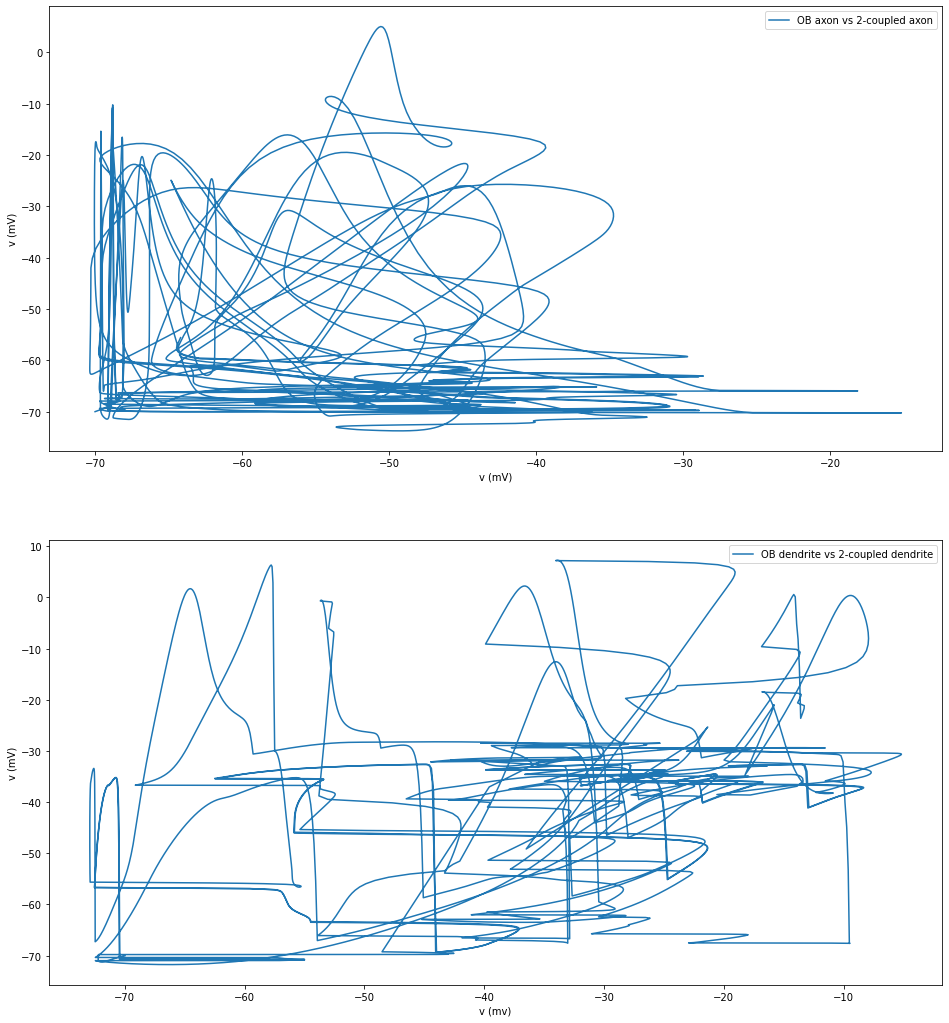

In [38]:
import numpy

OB_axon = []
OB_dend = []
two_axon = []
two_dend = []
for i in L1.sets:
    for j in enumerate(i.cells):
        if j[0] > 2:
            OB_axon.append(h.Vector().record(j[1].axon(0.5)._ref_v))
            OB_dend.append(h.Vector().record(j[1].dend(0.5)._ref_v))

for i in L1.sets:
    for j in enumerate(i.cells):
        if j[0] < 2:
            two_axon.append(h.Vector().record(j[1].axon(0.5)._ref_v))
            two_dend.append(h.Vector().record(j[1].dend(0.5)._ref_v))
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)

OB_axon_plot = np.mean(OB_axon, 0)
OB_dend_plot = np.mean(OB_dend, 0)
two_axon_plot = np.mean(two_axon, 0)
two_dend_plot = np.mean(two_dend, 0)

fig, axs = plt1.subplots(2, figsize=(16,18))
axs[0].plot(list(OB_axon_plot), list(two_axon_plot), label='OB axon vs 2-coupled axon')
axs[0].legend(loc="upper right")
axs[0].set_xlabel('v (mV)')
axs[0].set_ylabel('v (mV)')
axs[1].plot(list(OB_dend_plot),list(two_dend_plot), label='OB dendrite vs 2-coupled dendrite')
axs[1].legend(loc="upper right")
axs[1].set_xlabel('v (mv)')
axs[1].set_ylabel('v (mV)')
plt1.show()

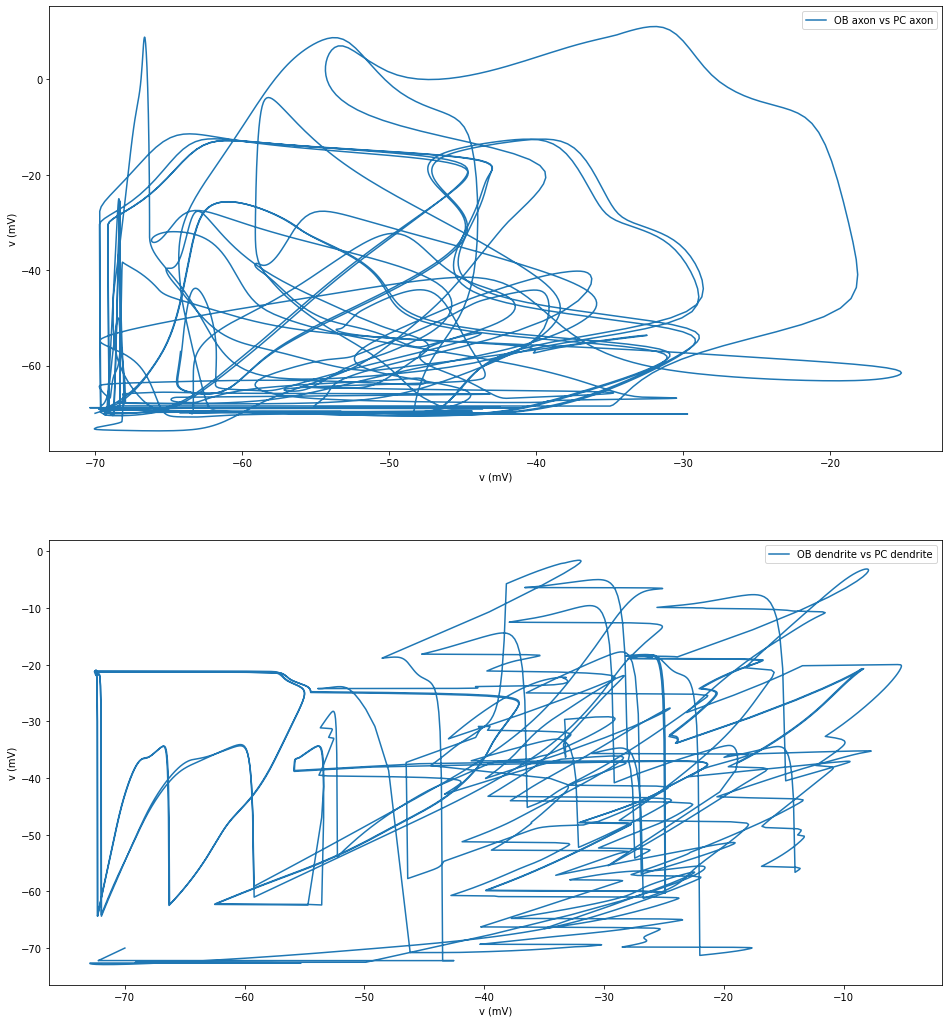

In [39]:
import numpy

OB_axon = []
OB_dend = []
PC_axon = []
PC_dend = []
for i in L1.sets:
    for j in enumerate(i.cells):
        if j[0] > 2:
            OB_axon.append(h.Vector().record(j[1].axon(0.5)._ref_v))
            OB_dend.append(h.Vector().record(j[1].dend(0.5)._ref_v))

for i in L1.PC.cells:
    PC_axon.append(h.Vector().record(i.axon(0.5)._ref_v))
    PC_dend.append(h.Vector().record(i.dend(0.5)._ref_v))
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)

OB_axon_plot = np.mean(OB_axon, 0)
OB_dend_plot = np.mean(OB_dend, 0)
PC_axon_plot = np.mean(PC_axon, 0)
PC_dend_plot = np.mean(PC_dend, 0)

fig, axs = plt1.subplots(2, figsize=(16,18))
axs[0].plot(list(OB_axon_plot), list(PC_axon_plot), label='OB axon vs PC axon')
axs[0].legend(loc="upper right")
axs[0].set_xlabel('v (mV)')
axs[0].set_ylabel('v (mV)')
axs[1].plot(list(OB_dend_plot),list(PC_dend_plot), label='OB dendrite vs PC dendrite')
axs[1].legend(loc="upper right")
axs[1].set_xlabel('v (mV)')
axs[1].set_ylabel('v (mV)')
plt1.show()

# Scatter Plots (Before Learning)

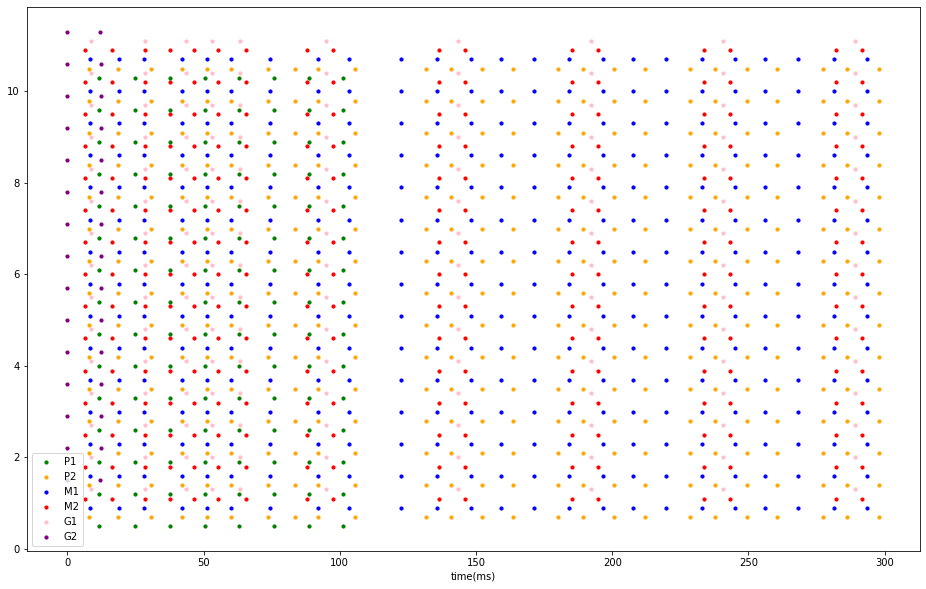

In [40]:
%matplotlib inline
h.finitialize(-70*mV)
h.continuerun(300*ms)
color=['green','orange','blue','red', 'pink', 'purple']
label=['P1', 'P2', 'M1','M2','G1','G2']
plt1.figure(figsize=(16,10))
for j in range(len(L1.sets)):
  #for i,cell in enumerate(L1.sets[j].cells):
    plt1.scatter(L1.sets[j].cells[0].spike_times, [0.5 + 0.7*j for i in range(len(L1.sets[j].cells[0].spike_times))], s=10,color=color[0]) # for P1
    plt1.scatter(L1.sets[j].cells[1].spike_times, [0.7 + 0.7*j for i in range(len(L1.sets[j].cells[1].spike_times))], s=10, color=color[1]) # for P2
    plt1.scatter(L1.sets[j].cells[2].spike_times, [0.9 + 0.7*j for i in range(len(L1.sets[j].cells[2].spike_times))], s=10, color=color[2]) # for M1
    plt1.scatter(L1.sets[j].cells[3].spike_times, [1.1 + 0.7*j for i in range(len(L1.sets[j].cells[3].spike_times))], s=10, color=color[3]) # for M2
    plt1.scatter(L1.sets[j].cells[4].spike_times, [1.3 + 0.7*j for i in range(len(L1.sets[j].cells[4].spike_times))], s=10, color=color[4]) # for G1
    plt1.scatter(L1.sets[j].cells[5].spike_times, [1.5 + 0.7*j for i in range(len(L1.sets[j].cells[5].spike_times))], s=10, color=color[5]) # for G2

plt1.xlabel('time(ms)')
plt1.legend(label)
plt1.show()

# Scratchpad

In [41]:
# P1_axon_data = []
# P2_axon_data = []
# M1_axon_data = []
# M2_axon_data = []
# G1_axon_data = []
# G2_axon_data = []


# for i in range(len(L1.sets)):
#     P1_axon_data.append(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v))
#     P2_axon_data.append(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v))
#     M1_axon_data.append(h.Vector().record(L1.sets[i].M1.axon(0.5)._ref_v))
#     M2_axon_data.append(h.Vector().record(L1.sets[i].M2.axon(0.5)._ref_v))
#     G1_axon_data.append(h.Vector().record(L1.sets[i].G1.axon(0.5)._ref_v))
#     G2_axon_data.append(h.Vector().record(L1.sets[i].G2.axon(0.5)._ref_v))

# t = h.Vector().record(h._ref_t)
# h.finitialize(-70* mV)
# h.continuerun(300*ms)

# print(P1_axon_data)    
# arr = np.array(P1_axon_data)
# back_to_the_list = list(arr.sum(axis=0))
# f = plt2.figure(x_axis_label='time')
# f.line(P2_axon_data[0],P1_axon_data[0], line_width=1, line_color='black')
# plt2.show(f)

In [42]:
pip install scipy pyinform pyopencl cython Jpype1

     |████████████████████████████████| 131 kB 15.2 MB/s 
     |████████████████████████████████| 884 kB 39.6 MB/s 
     |████████████████████████████████| 448 kB 48.0 MB/s 
     |████████████████████████████████| 69 kB 7.0 MB/s 
  Created wheel for pytools: filename=pytools-2022.1.7-py2.py3-none-any.whl size=64772 sha256=f8062c94b05af3c9143bb20ddffc8da44e1c99a663d3d0227cb369445816502c
  Stored in directory: /root/.cache/pip/wheels/24/c3/8d/9b093180175460a5fc613220b26027ae97cecbbf94fd3822af
Successfully built pytools


In [43]:
!apt-get install python3-pyopencl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  javascript-common libjs-jquery libjs-sphinxdoc libjs-underscore
  python-mako-doc python-numpy-doc python-pyopencl-doc python3-appdirs
  python3-cffi-backend python3-decorator python3-doc python3-mako
  python3-markupsafe python3-numpy python3-pkg-resources python3-pytools
  python3-six python3.6-doc
Suggested packages:
  apache2 | lighttpd | httpd python-mako python-pyopencl python3-examples
  python3-beaker python3-nose python3-numpy-dbg python3-setuptools
  python3-imaging-tk python3-opengl python3-pytest python3-matplotlib
  python3-pyopencl-dbg
The following NEW packages will be installed:
  javascript-common libjs-jquery libjs-sphinxdoc libjs-underscore
  python-mako-doc

In [44]:
!apt-get install openjdk-17-jre

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-17-jre-headless x11-utils
Suggested packages:
  libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-17-jre openjdk-17-jre-headless
  x11-utils
0 upgraded, 8 newly installed, 0 to remove and 42 not upgraded.
Need to get 46.9 MB of archives.
After this operation, 204 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64

In [45]:
%load_ext Cython

In [46]:
!apt-get install -y git
!git clone https://github.com/pwollstadt/IDTxl
!cd IDTxl && pip install .

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.11).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Cloning into 'IDTxl'...
remote: Enumerating objects: 7049, done.
remote: Total 7049 (delta 0), reused 0 (delta 0), pack-reused 7049
Receiving objects: 100% (7049/7049), 54.60 MiB | 30.19 MiB/s, done.
Resolving deltas: 100% (4534/4534), done.
Processing /content/IDTxl
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding thi

In [47]:
def learn():
    #@title Learning Mechanism { vertical-output: true }
    import sys, time
    tick = time.time()
    weight_data = []

    out = display(progress(0, epochs), display_id=True)

    for l in range(epochs):
        #print("iteration no is",l)
        out.update(progress(l, epochs))    
        # print("\nmutual learning")
        P1_axon_data = []
        P1_dend_data = []
        P2_axon_data = []
        P2_dend_data = []
        M1_axon_data = []
        M1_dend_data = []
        M2_axon_data = []
        M2_dend_data = []
        G1_axon_data = []
        G1_dend_data = []
        G2_axon_data = []
        G2_dend_data = []
        P1_spike_times = []
        P2_spike_times = []
        M1_spike_times = []
        M2_spike_times = []
        G1_spike_times = []
        G2_spike_times = []

        h.finitialize(-70* mV)
        h.continuerun(300*ms)
        t = h.Vector().record(h._ref_t)
        
        for i in range(len(L1.sets)):
            P1_axon_data.append(list(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)))
            P1_dend_data.append(list(h.Vector().record(L1.sets[i].P1.dend(0.5)._ref_v)))
            P1_spike_times.append(list(L1.sets[i].P1.spike_times))
            P2_axon_data.append(list(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v)))
            P2_spike_times.append(list(L1.sets[i].P2.spike_times))
            P2_dend_data.append(list(h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)))
            M1_axon_data.append(list(h.Vector().record(L1.sets[i].M1.axon(0.5)._ref_v)))
            M1_dend_data.append(list(h.Vector().record(L1.sets[i].M1.dend(0.5)._ref_v)))
            M1_spike_times.append(list(L1.sets[i].M1.spike_times))
            M2_axon_data.append(list(h.Vector().record(L1.sets[i].M2.axon(0.5)._ref_v)))
            M2_dend_data.append(list(h.Vector().record(L1.sets[i].M2.dend(0.5)._ref_v)))
            M2_spike_times.append(list(L1.sets[i].M2.spike_times))
            G1_axon_data.append(list(h.Vector().record(L1.sets[i].G1.axon(0.5)._ref_v)))
            G1_dend_data.append(list(h.Vector().record(L1.sets[i].G1.dend(0.5)._ref_v)))
            G1_spike_times.append(list(L1.sets[i].G1.spike_times))
            G2_axon_data.append(list(h.Vector().record(L1.sets[i].G2.axon(0.5)._ref_v)))
            G2_dend_data.append(list(h.Vector().record(L1.sets[i].G2.dend(0.5)._ref_v)))
            G2_spike_times.append(list(L1.sets[i].G2.spike_times))

    
        # h.finitialize(-70 * mV)

        for i in range(len(L1.sets)):
            # 2-coupled STDP-based learning
            L1.sets[i].nc1.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i])
            # logging
            # print("P1_axon", P1_spike_times[i], P2_spike_times[i])
            L1.sets[i].nc2.weight[0] += generate_L_weight_delta(P2_spike_times[i], P1_spike_times[i])
            L1.sets[i].nc3.weight[0] += generate_L_weight_delta(P1_spike_times[i], M1_spike_times[i])
            # 4-coupled STDP-based learning
            L1.sets[i].nc4.weight[0] += generate_L_weight_delta(M1_spike_times[i], M2_spike_times[i])
            L1.sets[i].nc5.weight[0] += generate_L_weight_delta(M2_spike_times[i], M1_spike_times[i])
            L1.sets[i].nc6.weight[0] += generate_L_weight_delta(M2_spike_times[i], G1_spike_times[i])
            L1.sets[i].nc7.weight[0] += generate_L_weight_delta(G1_spike_times[i], M2_spike_times[i])
            L1.sets[i].nc8.weight[0] += generate_L_weight_delta(G1_spike_times[i], G2_spike_times[i])
            L1.sets[i].nc9.weight[0] += generate_L_weight_delta(G2_spike_times[i], G1_spike_times[i])
            L1.sets[i].nc10.weight[0] += generate_L_weight_delta(G2_spike_times[i], M1_spike_times[i])
            L1.sets[i].nc11.weight[0] += generate_L_weight_delta(M1_spike_times[i], G2_spike_times[i])
            L1.sets[i].nc12.weight[0] += generate_L_weight_delta(M1_spike_times[i], G1_spike_times[i])
            L1.sets[i].nc13.weight[0] += generate_L_weight_delta(G1_spike_times[i], M1_spike_times[i])
            # L1.sets[i].DPC.weight[0] += generate_L_weight_delta(G1_spike_times[i], M1_spike_times[i])
            
        # do a proper logging function
        weight_data.append(L1.sets[0].nc1.weight[0])


        #Lateral Learning
        for i in range(len(L1.sets)-1):
            # 2-coupled part
            L1.twoCupArr[i][0].weight[0] += generate_L_weight_delta(P1_spike_times[i], P1_spike_times[i+1])
            L1.twoCupArr[i][1].weight[0] += generate_L_weight_delta(P1_spike_times[i+1], P1_spike_times[i])
            # 4-coupled part
            L1.fourCupArr[i][0].weight[0] += generate_L_weight_delta(M1_spike_times[i], M1_spike_times[i+1])
            L1.fourCupArr[i][1].weight[0] += generate_L_weight_delta(M1_spike_times[i+1], M1_spike_times[i])
            L1.fourCupArr[i][2].weight[0] += generate_L_weight_delta(G1_spike_times[i], G1_spike_times[i+1])
            L1.fourCupArr[i][3].weight[0] += generate_L_weight_delta(G1_spike_times[i+1], G1_spike_times[i])
        # plotCell(L1.sets[-1].M1, 'M1')


    out.update(progress(epochs, epochs))    
    tock = time.time()
    print("The time it took to learn", tock-tick, "seconds")

The time it took to learn 55.51577806472778 seconds
Adding data with properties: 15 processes, 12001 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2)]
testing candidate: (3, 2) maximum statistic, n_perm: 200
testing candidate: (13, 2) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(

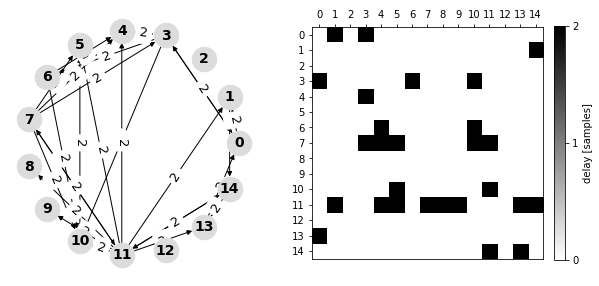

In [48]:
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jpype as jp
learn()
P1Arr = []
for i in range(len(L1.sets)):
    P1Arr.append(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v))
    

h.finitialize(-70*mV)
h.continuerun(300*ms)
P1 = np.array([list(i) for i in P1Arr])
data = Data(P1, dim_order='ps')
network_analysis = MultivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': 2,
            'min_lag_sources': 2}

# c) Run analysis
P1results = network_analysis.analyse_network(settings=settings, data=data)
# d) Plot inferred network to console and via matplotlib
P1results.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=P1results, weights='max_te_lag', fdr=False)
plt.show()

Adding data with properties: 15 processes, 12001 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2)]
testing candidate: (1, 2) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 2),

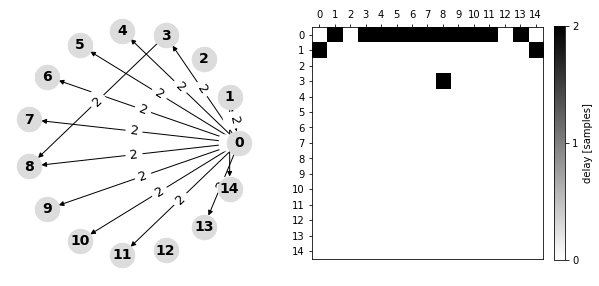

In [49]:
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jpype as jp

P2Arr = []
for i in range(len(L1.sets)):
    P2Arr.append(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v))
    

h.finitialize(-70*mV)
h.continuerun(300*ms)
P2 = np.array([list(i) for i in P2Arr])
data = Data(P2, dim_order='ps')
network_analysis = MultivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': 2,
            'min_lag_sources': 2}

# c) Run analysis
P2results = network_analysis.analyse_network(settings=settings, data=data)
# d) Plot inferred network to console and via matplotlib
P2results.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=P2results, weights='max_te_lag', fdr=False)
plt.show()

Adding data with properties: 15 processes, 12001 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2)]
testing candidate: (1, 2) maximum statistic, n_perm: 200
testing candidate: (12, 2) maximum statistic, n_perm: 200
testing candidate: (11, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 2), (12, 2)]
testing candidate: (12, 2) minimum 

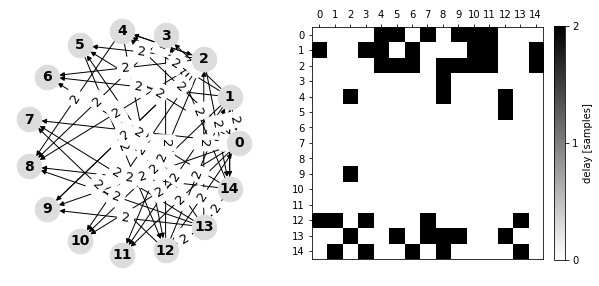

In [50]:
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jpype as jp

M1Arr = []
for i in range(len(L1.sets)):
    M1Arr.append(h.Vector().record(L1.sets[i].M1.axon(0.5)._ref_v))
    
h.finitialize(-70*mV)
h.continuerun(300*ms)
M1 = np.array([list(i) for i in M1Arr])
data = Data(M1, dim_order='ps')
network_analysis = MultivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': 2,
            'min_lag_sources': 2}

# c) Run analysis
M1results = network_analysis.analyse_network(settings=settings, data=data)
# d) Plot inferred network to console and via matplotlib
M1results.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=M1results, weights='max_te_lag', fdr=False)
plt.show()

Adding data with properties: 15 processes, 12001 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2)]
testing candidate: (1, 2) maximum statistic, n_perm: 200
testing candidate: (12, 2) maximum statistic, n_perm: 200
testing candidate: (11, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 2), (12, 2)]
testing candidate: (12, 2) minimum 

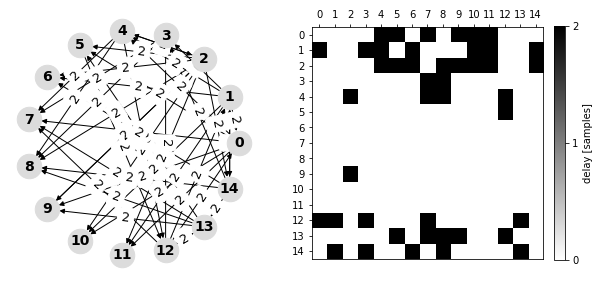

In [51]:
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jpype as jp

M2Arr = []
for i in range(len(L1.sets)):
    M2Arr.append(h.Vector().record(L1.sets[i].M1.axon(0.5)._ref_v))
    
h.finitialize(-70*mV)
h.continuerun(300*ms)
M2 = np.array([list(i) for i in M2Arr])
data = Data(M2, dim_order='ps')
network_analysis = MultivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': 2,
            'min_lag_sources': 2}

# c) Run analysis
M2results = network_analysis.analyse_network(settings=settings, data=data)
# d) Plot inferred network to console and via matplotlib
M2results.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=M2results, weights='max_te_lag', fdr=False)
plt.show()

Adding data with properties: 15 processes, 12001 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2)]
testing candidate: (1, 2) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 2),

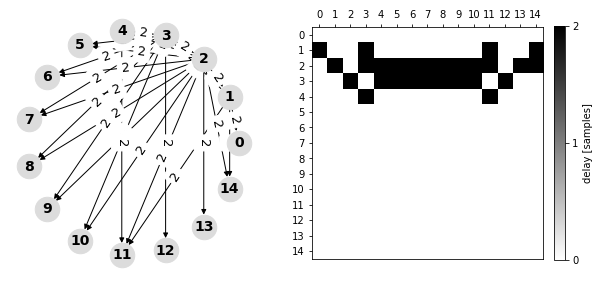

In [52]:
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jpype as jp

G1Arr = []
for i in range(len(L1.sets)):
    G1Arr.append(h.Vector().record(L1.sets[i].G1.axon(0.5)._ref_v))
    
h.finitialize(-70*mV)
h.continuerun(300*ms)
G1 = np.array([list(i) for i in G1Arr])
data = Data(G1, dim_order='ps')
network_analysis = MultivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': 2,
            'min_lag_sources': 2}

# c) Run analysis
G1results = network_analysis.analyse_network(settings=settings, data=data)
# d) Plot inferred network to console and via matplotlib
G1results.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=G1results, weights='max_te_lag', fdr=False)
plt.show()

Adding data with properties: 15 processes, 12001 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2)]
testing candidate: (3, 2) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 2),

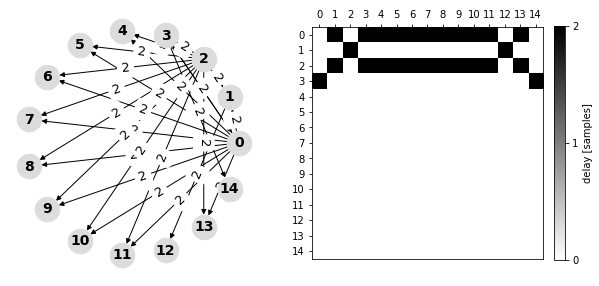

In [53]:
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jpype as jp

G2Arr = []
for i in range(len(L1.sets)):
    G2Arr.append(h.Vector().record(L1.sets[i].G2.axon(0.5)._ref_v))
    
h.finitialize(-70*mV)
h.continuerun(300*ms)
G2 = np.array([list(i) for i in G2Arr])
data = Data(G2, dim_order='ps')
network_analysis = MultivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': 2,
            'min_lag_sources': 2}

# c) Run analysis
G2results = network_analysis.analyse_network(settings=settings, data=data)
# d) Plot inferred network to console and via matplotlib
G2results.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=G2results, weights='max_te_lag', fdr=False)
plt.show()

In [55]:
print(P1results.__dict__)
print(P2results.__dict__)
print(M1results.__dict__)
print(M2results.__dict__)
print(G1results.__dict__)
print(G2results.__dict__)

{'settings': {'cmi_estimator': 'JidtGaussianCMI', 'max_lag_sources': 2, 'min_lag_sources': 2, 'verbose': True, 'fdr_correction': True, 'write_ckp': False, 'add_conditionals': None, 'tau_target': 1, 'tau_sources': 1, 'local_values': False, 'max_lag_target': 2, 'debug': False, 'n_perm_max_stat': 200, 'alpha_max_stat': 0.05, 'permute_in_time': True, 'perm_type': 'random', 'analytical_surrogates': True, 'n_perm_min_stat': 500, 'alpha_min_stat': 0.05, 'n_perm_omnibus': 500, 'alpha_omnibus': 0.05, 'n_perm_max_seq': 500, 'alpha_max_seq': 0.05, 'alpha_fdr': 0.05, 'fdr_correct_by_target': True, 'fdr_constant': 2}, 'data_properties': {'n_nodes': 15, 'n_realisations': 11999, 'normalised': True}, '_single_target': {0: {'sources_tested': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'current_value': (0, 2), 'selected_vars_target': [(0, 1), (0, 2)], 'selected_vars_sources': [(3, 2), (13, 2)], 'selected_sources_pval': array([0.002, 0.002]), 'selected_sources_te': array([0.00370331, 0.00076152]), '

# Learning

In [ ]:
#@title Learning Mechanism { vertical-output: true }
import sys, time
tick = time.time()
weight_data = []

out = display(progress(0, epochs), display_id=True)

for l in range(epochs):
    #print("iteration no is",l)
    out.update(progress(l, epochs))    
    # print("\nmutual learning")
    P1_axon_data = []
    P1_dend_data = []
    P2_axon_data = []
    P2_dend_data = []
    M1_axon_data = []
    M1_dend_data = []
    M2_axon_data = []
    M2_dend_data = []
    G1_axon_data = []
    G1_dend_data = []
    G2_axon_data = []
    G2_dend_data = []
    P1_spike_times = []
    P2_spike_times = []
    M1_spike_times = []
    M2_spike_times = []
    G1_spike_times = []
    G2_spike_times = []

    h.finitialize(-70* mV)
    h.continuerun(300*ms)
    t = h.Vector().record(h._ref_t)
    
    for i in range(len(L1.sets)):
        P1_axon_data.append(list(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)))
        P1_dend_data.append(list(h.Vector().record(L1.sets[i].P1.dend(0.5)._ref_v)))
        P1_spike_times.append(list(L1.sets[i].P1.spike_times))
        P2_axon_data.append(list(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v)))
        P2_spike_times.append(list(L1.sets[i].P2.spike_times))
        P2_dend_data.append(list(h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)))
        M1_axon_data.append(list(h.Vector().record(L1.sets[i].M1.axon(0.5)._ref_v)))
        M1_dend_data.append(list(h.Vector().record(L1.sets[i].M1.dend(0.5)._ref_v)))
        M1_spike_times.append(list(L1.sets[i].M1.spike_times))
        M2_axon_data.append(list(h.Vector().record(L1.sets[i].M2.axon(0.5)._ref_v)))
        M2_dend_data.append(list(h.Vector().record(L1.sets[i].M2.dend(0.5)._ref_v)))
        M2_spike_times.append(list(L1.sets[i].M2.spike_times))
        G1_axon_data.append(list(h.Vector().record(L1.sets[i].G1.axon(0.5)._ref_v)))
        G1_dend_data.append(list(h.Vector().record(L1.sets[i].G1.dend(0.5)._ref_v)))
        G1_spike_times.append(list(L1.sets[i].G1.spike_times))
        G2_axon_data.append(list(h.Vector().record(L1.sets[i].G2.axon(0.5)._ref_v)))
        G2_dend_data.append(list(h.Vector().record(L1.sets[i].G2.dend(0.5)._ref_v)))
        G2_spike_times.append(list(L1.sets[i].G2.spike_times))

   
    # h.finitialize(-70 * mV)

    for i in range(len(L1.sets)):
        # 2-coupled STDP-based learning
        L1.sets[i].nc1.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i])
        # logging
        # print("P1_axon", P1_spike_times[i], P2_spike_times[i])
        L1.sets[i].nc2.weight[0] += generate_L_weight_delta(P2_spike_times[i], P1_spike_times[i])
        L1.sets[i].nc3.weight[0] += generate_L_weight_delta(P1_spike_times[i], M1_spike_times[i])
        # 4-coupled STDP-based learning
        L1.sets[i].nc4.weight[0] += generate_L_weight_delta(M1_spike_times[i], M2_spike_times[i])
        L1.sets[i].nc5.weight[0] += generate_L_weight_delta(M2_spike_times[i], M1_spike_times[i])
        L1.sets[i].nc6.weight[0] += generate_L_weight_delta(M2_spike_times[i], G1_spike_times[i])
        L1.sets[i].nc7.weight[0] += generate_L_weight_delta(G1_spike_times[i], M2_spike_times[i])
        L1.sets[i].nc8.weight[0] += generate_L_weight_delta(G1_spike_times[i], G2_spike_times[i])
        L1.sets[i].nc9.weight[0] += generate_L_weight_delta(G2_spike_times[i], G1_spike_times[i])
        L1.sets[i].nc10.weight[0] += generate_L_weight_delta(G2_spike_times[i], M1_spike_times[i])
        L1.sets[i].nc11.weight[0] += generate_L_weight_delta(M1_spike_times[i], G2_spike_times[i])
        L1.sets[i].nc12.weight[0] += generate_L_weight_delta(M1_spike_times[i], G1_spike_times[i])
        L1.sets[i].nc13.weight[0] += generate_L_weight_delta(G1_spike_times[i], M1_spike_times[i])
        # L1.sets[i].DPC.weight[0] += generate_L_weight_delta(G1_spike_times[i], M1_spike_times[i])
        
    # do a proper logging function
    weight_data.append(L1.sets[0].nc1.weight[0])


    #Lateral Learning
    for i in range(len(L1.sets)-1):
        # 2-coupled part
        L1.twoCupArr[i][0].weight[0] += generate_L_weight_delta(P1_spike_times[i], P1_spike_times[i+1])
        L1.twoCupArr[i][1].weight[0] += generate_L_weight_delta(P1_spike_times[i+1], P1_spike_times[i])
        # 4-coupled part
        L1.fourCupArr[i][0].weight[0] += generate_L_weight_delta(M1_spike_times[i], M1_spike_times[i+1])
        L1.fourCupArr[i][1].weight[0] += generate_L_weight_delta(M1_spike_times[i+1], M1_spike_times[i])
        L1.fourCupArr[i][2].weight[0] += generate_L_weight_delta(G1_spike_times[i], G1_spike_times[i+1])
        L1.fourCupArr[i][3].weight[0] += generate_L_weight_delta(G1_spike_times[i+1], G1_spike_times[i])
    # plotCell(L1.sets[-1].M1, 'M1')


out.update(progress(epochs, epochs))    
tock = time.time()
print("The time it took to learn", tock-tick, "seconds")

In [ ]:
#@title Time Taken { vertical-output: true }
totalend = time.time()
print("Total time it took: ", totalend-totalstart)

# Voltage vs Voltage Analysis (After Learning)

In [ ]:
import numpy

OB_axon = []
OB_dend = []
AON_axon = []
AON_dend = []
for i in L1.sets:
    for j in enumerate(i.cells):
        if j[0] > 2:
            OB_axon.append(h.Vector().record(j[1].axon(0.5)._ref_v))
            OB_dend.append(h.Vector().record(j[1].dend(0.5)._ref_v))

for i in L1.AON.cells:
    AON_axon.append(h.Vector().record(i.axon(0.5)._ref_v))
    AON_dend.append(h.Vector().record(i.dend(0.5)._ref_v))
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)

OB_axon_plot = np.mean(OB_axon, 0)
OB_dend_plot = np.mean(OB_dend, 0)
AON_axon_plot = np.mean(AON_axon, 0)
AON_dend_plot = np.mean(AON_dend, 0)

fig, axs = plt1.subplots(2, figsize=(16,18))
axs[0].plot(list(OB_axon_plot), list(AON_axon_plot), label='OB axon vs AON axon')
axs[0].legend(loc="upper right")
axs[0].set_xlabel('v (mV)')
axs[0].set_ylabel('v (mV)')
axs[1].plot(list(OB_dend_plot),list(AON_dend_plot), label='OB dendrite vs AON dendrite')
axs[1].legend(loc="upper right")
axs[1].set_xlabel('v (mV)')
axs[1].set_ylabel('v (mV)')
plt1.show()

In [ ]:
import numpy

OB_axon = []
OB_dend = []
two_axon = []
two_dend = []
for i in L1.sets:
    for j in enumerate(i.cells):
        if j[0] > 2:
            OB_axon.append(h.Vector().record(j[1].axon(0.5)._ref_v))
            OB_dend.append(h.Vector().record(j[1].dend(0.5)._ref_v))

for i in L1.sets:
    for j in enumerate(i.cells):
        if j[0] < 2:
            two_axon.append(h.Vector().record(j[1].axon(0.5)._ref_v))
            two_dend.append(h.Vector().record(j[1].dend(0.5)._ref_v))
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)

OB_axon_plot = np.mean(OB_axon, 0)
OB_dend_plot = np.mean(OB_dend, 0)
two_axon_plot = np.mean(two_axon, 0)
two_dend_plot = np.mean(two_dend, 0)

fig, axs = plt1.subplots(2, figsize=(16,18))
axs[0].plot(list(OB_axon_plot), list(two_axon_plot), label='OB axon vs 2-coupled axon')
axs[0].legend(loc="upper right")
axs[0].set_xlabel('v (mV)')
axs[0].set_ylabel('v (mV)')
axs[1].plot(list(OB_dend_plot),list(two_dend_plot), label='OB dendrite vs 2-coupled dendrite')
axs[1].legend(loc="upper right")
axs[1].set_xlabel('v (mV)')
axs[1].set_ylabel('v (mV)')
plt1.show()

In [ ]:
import numpy

OB_axon = []
OB_dend = []
PC_axon = []
PC_dend = []
for i in L1.sets:
    for j in enumerate(i.cells):
        if j[0] > 2:
            OB_axon.append(h.Vector().record(j[1].axon(0.5)._ref_v))
            OB_dend.append(h.Vector().record(j[1].dend(0.5)._ref_v))

for i in L1.PC.cells:
    PC_axon.append(h.Vector().record(i.axon(0.5)._ref_v))
    PC_dend.append(h.Vector().record(i.dend(0.5)._ref_v))
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)

OB_axon_plot = np.mean(OB_axon, 0)
OB_dend_plot = np.mean(OB_dend, 0)
PC_axon_plot = np.mean(PC_axon, 0)
PC_dend_plot = np.mean(PC_dend, 0)

fig, axs = plt1.subplots(2, figsize=(16,18))
axs[0].plot(list(OB_axon_plot), list(PC_axon_plot), label='OB axon vs PC axon')
axs[0].legend(loc="upper right")
axs[0].set_xlabel('v (mV)')
axs[0].set_ylabel('v (mV)')
axs[1].plot(list(OB_dend_plot),list(PC_dend_plot), label='OB dendrite vs PC dendrite')
axs[1].legend(loc="upper right")
axs[1].set_xlabel('v (mV)')
axs[1].set_ylabel('v (mV)')
plt1.show()

In [ ]:
recording_cell = L1.sets[-1].M1
recording_cell_2 = L1.AON.M1
axon_m1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
dend_m1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
axon_m2 = h.Vector().record(recording_cell_2.axon(0.5)._ref_v)
dend_m2 = h.Vector().record(recording_cell_2.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)

# f = plt2.figure(x_axis_label='M1 Axon v (mV)', y_axis_label='AON Axon v (mV)')
# f.line(list(axon_m1), list(axon_m2), line_width=1,legend_label='4-coupled M1 axon vs AON axon',line_color='black')
# f2 = plt2.figure(x_axis_label='M1 Dendrite v (mV)', y_axis_label='AON dendrite v (mV)')
# f2.line(list(dend_m1), list(dend_m2), line_width=2,legend_label='4-coupled M1 dendrite vs AON dendrite',line_color='black')
# plt2.show(f)
# plt2.show(f2)

fig, axs = plt1.subplots(2, figsize=(16,18))
axs[0].plot(list(axon_m1), list(axon_m2), label='4-coupled M1 axon vs AON axon')
axs[0].legend(loc="upper right")
axs[0].set_xlabel('v (mV)')
axs[0].set_ylabel('v (mV)')
axs[1].plot(list(dend_m1),list(dend_m2), label='4-coupled M1 dendrite vs AON dendrite')
axs[1].legend(loc="upper right")
axs[1].set_xlabel('v (mV)')
axs[1].set_ylabel('v (mV)')
plt1.show()

# Weights (While Learning)

In [ ]:
print(weight_data)
f = plt1.figure()
x = [i for i in range(epochs)]
# f.line(x, weight_data, line_width=1, line_color='black')
plt1.plot(x, weight_data)
plt1.show(f)

# Voltages (After Learning)

In [ ]:
plotCell(L1.sets[-1].P1, 'P1')

In [ ]:
plotCell(L1.sets[-1].P2, 'P2')

In [ ]:
plotCell(L1.sets[-1].M1, 'M1')

In [ ]:
plotCell(L1.sets[-1].G1, 'G1')

In [ ]:
plotCell(L1.sets[-1].M2, 'M2')

In [ ]:
plotCell(L1.sets[-1].G2, 'G2')

In [ ]:
plotCell(L1.DPC, 'DPC')

In [ ]:
plotCell(L1.AON.M1, 'AON')

In [ ]:
plotCell(L1.PC.G1, 'Pyramidal Cell')

# Scatter Plots (After Learning)

In [ ]:
%matplotlib inline
h.finitialize(-70*mV)
h.continuerun(300*ms)
color=['green','orange','blue','red', 'pink', 'purple']
label=['P1', 'P2', 'M1','M2','G1','G2']
plt1.figure(figsize=(16,10))
for j in range(len(L1.sets)):
  #for i,cell in enumerate(L1.sets[j].cells):
    plt1.scatter(L1.sets[j].cells[0].spike_times, [0.5 + 0.7*j for i in range(len(L1.sets[j].cells[0].spike_times))], s=10,color=color[0]) # for P1
    plt1.scatter(L1.sets[j].cells[1].spike_times, [0.7 + 0.7*j for i in range(len(L1.sets[j].cells[1].spike_times))], s=10, color=color[1]) # for P2
    plt1.scatter(L1.sets[j].cells[2].spike_times, [0.9 + 0.7*j for i in range(len(L1.sets[j].cells[2].spike_times))], s=10, color=color[2]) # for M1
    plt1.scatter(L1.sets[j].cells[3].spike_times, [1.1 + 0.7*j for i in range(len(L1.sets[j].cells[3].spike_times))], s=10, color=color[3]) # for M2
    plt1.scatter(L1.sets[j].cells[4].spike_times, [1.3 + 0.7*j for i in range(len(L1.sets[j].cells[4].spike_times))], s=10, color=color[4]) # for G1
    plt1.scatter(L1.sets[j].cells[5].spike_times, [1.5 + 0.7*j for i in range(len(L1.sets[j].cells[5].spike_times))], s=10, color=color[5]) # for G2

plt1.xlabel('time(ms)')
plt1.legend(label)
plt1.show()

# Scratchpad 

In [ ]:
name = 'DPC'
addendum=""
recording_cell = L1.DPC
cell_axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
cell_dend = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(cell_axon), line_width=1,legend_label=name+' axon '+addendum,line_color='black')
f.line(t, list(cell_dend), line_width=2,legend_label=name+' dendrite '+addendum,line_color='red', line_dash='dashed')
plt2.show(f)